# XLM-ROBERTA Fine Tuning Pipeline
This notebook automates the fine tuning of NLP model XLM-ROBERTA


## Setup & Imports


In [39]:
from datasets import load_dataset, Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers.trainer_utils import get_last_checkpoint
from transformers.tokenization_utils_base import PreTrainedTokenizerBase
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score
from torch.nn import CrossEntropyLoss
import torch
import torch.nn as nn
import torch.nn.functional as F
import evaluate
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
from tqdm import tqdm
from typing import List

## Configurations


In [7]:
DATA_PATHS = [
  "../../data/nlp/tweet_emotions.csv",
  "../../data/nlp/Sentiment-analysis-for-mental-health.csv"
]
MODEL_NAME = "xlm-roberta-base"

MODEL_PATH_FINETUNE_1 = "../../models/nlp/sentiment_finetune_1"
MODEL_PATH_MODEL_1 = "../../models/nlp/sentiment_model_1"

MODEL_PATH_FINETUNE_2 = "../../models/nlp/sentiment_finetune_2"
MODEL_PATH_MODEL_2 = "../../models/nlp/sentiment_model_2"


## Load Data

In [8]:
# Load two datasets
dataset_1_broad_emotion = load_dataset("csv", data_files=DATA_PATHS[0])
dataset_2_specialize = load_dataset("csv", data_files=DATA_PATHS[1])

# Define functions to rename datasets
def rename_data_columns(data: Dataset, column_names_to_change: List[str], new_column_names: List[str]) -> Dataset:
    if len(column_names_to_change) != len(new_column_names):
        raise ValueError("Both lists must have the same length.")
    
    dataset = data
    for old_name, new_name in zip(column_names_to_change, new_column_names):
        dataset = dataset.rename_column(old_name, new_name)

    print(dataset)
    
    return dataset

# Remove unwanted column
dataset_1_broad_emotion = dataset_1_broad_emotion.remove_columns(["tweet_id"])
dataset_2_specialize = dataset_2_specialize.remove_columns(["Unnamed: 0"])

# Rename
print("\nDataset: tweet_emotions")
dataset_1_broad_emotion = rename_data_columns(
    data=dataset_1_broad_emotion,
    column_names_to_change=['sentiment', 'content'],
    new_column_names=['labels', 'text']
  )

print("\nDataset: Sentiment-analysis-for-mental-health")
dataset_2_specialize = rename_data_columns(
    data=dataset_2_specialize,
    column_names_to_change=['status', 'statement'],
    new_column_names=['labels', 'text']
  )



Dataset: tweet_emotions
DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 40000
    })
})

Dataset: Sentiment-analysis-for-mental-health
DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 53043
    })
})


## Data Pre-processing & Visualization


### Check unique labels



#### labels visualization


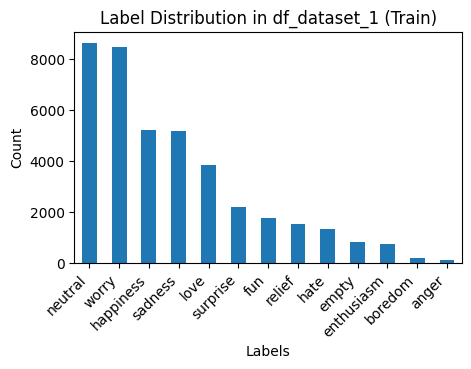

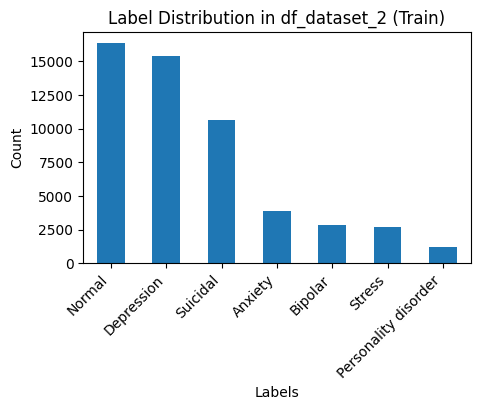

In [10]:
def label_visualization():
  # Convert data to pandas dataframe for visualization
  df_dataset_1 = dataset_1_broad_emotion["train"].to_pandas()
  df_dataset_2 = dataset_2_specialize["train"].to_pandas()

  # Count label frequencies
  label_for_df1_counts = df_dataset_1["labels"].value_counts()
  label_for_df2_counts = df_dataset_2["labels"].value_counts()

  # Plot distribution for df_dataset_1
  plt.figure(figsize=(5, 3))
  label_for_df1_counts.plot(kind="bar")
  plt.xticks(rotation=45, ha="right")
  plt.title("Label Distribution in df_dataset_1 (Train)")
  plt.xlabel("Labels")
  plt.ylabel("Count")
  plt.show()

  # Plot distribution for df_dataset_2
  plt.figure(figsize=(5, 3))
  label_for_df2_counts.plot(kind="bar")
  plt.xticks(rotation=45, ha="right")
  plt.title("Label Distribution in df_dataset_2 (Train)")
  plt.xlabel("Labels")
  plt.ylabel("Count")
  plt.show()

label_visualization()

#### label pre-process

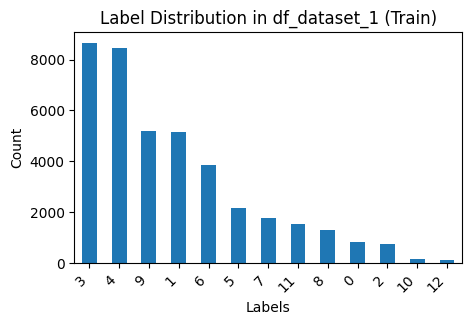

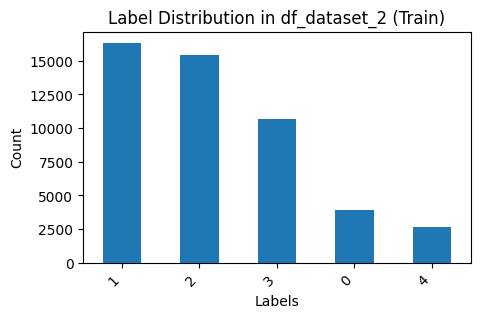

In [11]:
# Get unique labels
labels_1 = dataset_1_broad_emotion["train"].unique("labels")
label_1_to_id = {l: i for i, l in enumerate(labels_1)}
id_1_to_label = {i: l for l, i in label_1_to_id.items()}

labels_2 = dataset_2_specialize["train"].unique("labels")
label_2_to_id = {l: i for i, l in enumerate(labels_2)}
id_2_to_label = {i: l for l, i in label_2_to_id.items()}

# Based on the graphs above i don't want "Bipolar", "Personality disorder"
unwanted_labels = ["Bipolar", "Personality disorder"]
dataset_2_specialize["train"] = dataset_2_specialize["train"].filter(
    lambda example: example["labels"] not in unwanted_labels
)

def make_label_encoder(label_to_id: dict, column_name: str = "labels"):
    """Returns a function that encodes labels for the given column using label_to_id mapping."""
    def encode_labels(example):
        example[column_name] = label_to_id[example[column_name]]
        return example
    return encode_labels

encoder_for_data1 = make_label_encoder(label_1_to_id, column_name="labels")
encoder_for_data2 = make_label_encoder(label_2_to_id, column_name="labels")

dataset_1_broad_emotion = dataset_1_broad_emotion.map(encoder_for_data1)
dataset_2_specialize = dataset_2_specialize.map(encoder_for_data2)

# Re check if changes were applied correctly
label_visualization()


### Remove special characters

In [13]:
def clean_text(example):
    text = example.get("text", "")

    if text is None or not isinstance(text, str) or text.strip() == "":
        return {"text": ""}   # keep it empty; will be dropped later

    # Lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'https?://\S+', '', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove newlines and other non-word characters except spaces
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return {"text": text}


dataset_1_broad_emotion = dataset_1_broad_emotion.map(clean_text)
dataset_2_specialize = dataset_2_specialize.map(clean_text)

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/48965 [00:00<?, ? examples/s]

### Check for rows that has null or blank values

In [14]:
def check_for_null_blank(dataset, dataset_name="Dataset"):
    import pandas as pd

    # If it's a DatasetDict, loop over splits
    if hasattr(dataset, "keys"):  # DatasetDict
        for split in dataset.keys():
            print(f"Checking split: {split} in {dataset_name}\n")
            df = dataset[split].to_pandas()
            
            # Nulls
            print("Nulls in each column:")
            print(df[["text", "labels"]].isnull().sum())
            print("\n")
            
            # Rows with nulls
            print("Rows where text or labels are null/blank:")
            print(df[df["text"].isnull() | df["labels"].isnull()])
            print("\n")
            
            # Blank strings
            print("Check for blank and empty string values:")
            print("Blank texts:", (df["text"].str.strip() == "").sum())
            print("Blank labels:", (df["labels"].astype(str).str.strip() == "").sum())
            print("\n")
    else:  # Single Dataset
        df = dataset.to_pandas()
        print(f"Checking {dataset_name}\n")
        print("Nulls in each column:")
        print(df[["text", "labels"]].isnull().sum())
        print("\n")
        print("Rows where text or labels are null/blank:")
        print(df[df["text"].isnull() | df["labels"].isnull()])
        print("\n")
        print("Check for blank and empty string values:")
        print("Blank texts:", (df["text"].str.strip() == "").sum())
        print("Blank labels:", (df["labels"].astype(str).str.strip() == "").sum())
        print("\n")

check_for_null_blank(dataset_1_broad_emotion, "Dataset 1")
check_for_null_blank(dataset_2_specialize, "Dataset 2")


Checking split: train in Dataset 1

Nulls in each column:
text      0
labels    0
dtype: int64


Rows where text or labels are null/blank:
Empty DataFrame
Columns: [labels, text]
Index: []


Check for blank and empty string values:
Blank texts: 4
Blank labels: 0


Checking split: train in Dataset 2

Nulls in each column:
text      0
labels    0
dtype: int64


Rows where text or labels are null/blank:
Empty DataFrame
Columns: [text, labels]
Index: []


Check for blank and empty string values:
Blank texts: 145
Blank labels: 0




### Drop rows that has null / blank / empty string values

In [15]:
# Drop rows where statement or status is null
def drop_nulls_from_dataset(dataset, columns=["text", "labels"]):
    """
    Drops null and blank values from a Dataset or DatasetDict.
    Works for both cases.
    """
    if isinstance(dataset, DatasetDict):  # Case 1: DatasetDict with train/test
        cleaned_splits = {}
        for split_name, ds_split in dataset.items():
            df = ds_split.to_pandas()
            df = df.dropna(subset=columns)
            if "text" in columns:
                df = df[df["text"].str.strip() != ""]
            cleaned_splits[split_name] = Dataset.from_pandas(df)
            print(f"✅ Cleaned {split_name}: {len(ds_split)} → {len(df)} rows")
        return DatasetDict(cleaned_splits)

    elif isinstance(dataset, Dataset):  # Case 2: Single Dataset
        df = dataset.to_pandas()
        df = df.dropna(subset=columns)
        if "text" in columns:
            df = df[df["text"].str.strip() != ""]
        cleaned_dataset = Dataset.from_pandas(df)
        print(f"✅ Cleaned dataset: {len(dataset)} → {len(df)} rows")
        return cleaned_dataset

    else:
        raise TypeError("Expected Dataset or DatasetDict")

dataset_1_broad_emotion = drop_nulls_from_dataset(dataset_1_broad_emotion)
dataset_2_specialize = drop_nulls_from_dataset(dataset_2_specialize)

# Check counts again
check_for_null_blank(dataset_1_broad_emotion);
check_for_null_blank(dataset_2_specialize);

✅ Cleaned train: 40000 → 39996 rows
✅ Cleaned train: 48965 → 48820 rows
Checking split: train in Dataset

Nulls in each column:
text      0
labels    0
dtype: int64


Rows where text or labels are null/blank:
Empty DataFrame
Columns: [labels, text, __index_level_0__]
Index: []


Check for blank and empty string values:
Blank texts: 0
Blank labels: 0


Checking split: train in Dataset

Nulls in each column:
text      0
labels    0
dtype: int64


Rows where text or labels are null/blank:
Empty DataFrame
Columns: [text, labels, __index_level_0__]
Index: []


Check for blank and empty string values:
Blank texts: 0
Blank labels: 0




### Check thhe max length the text column contains

In [16]:
def get_min_max_len(example):
  lengths = example["train"].to_pandas()['text'].str.len()

  max_length = lengths.max()
  min_length = lengths.min()
  short_texts_count = (lengths <= min_length).sum()
  long_texts_count = (lengths >= max_length).sum()

  print(f"Max: {max_length}")
  print(f"Min: {min_length}")
  print(f'Short text count: {short_texts_count}')
  print(f'Long text count: {long_texts_count}')

print("Dataset 1")
get_min_max_len(dataset_1_broad_emotion)
print('\nDataset 2')
get_min_max_len(dataset_2_specialize)

Dataset 1
Max: 151
Min: 3
Short text count: 1
Long text count: 1

Dataset 2
Max: 31499
Min: 2
Short text count: 8
Long text count: 1


### Split training data to validation to test

In [17]:
def split_dataset_to_train_valid_test(dataset: DatasetDict, test_size: float = 0.2, val_size: float = 0.2, seed: int = 42) -> DatasetDict:
    """
    Splits a dataset into train, validation, and test sets.
    - First, takes a portion (test_size) from 'train' to make the test set.
    - Then, splits the remaining train into train/validation (val_size).
    """
    if "train" not in dataset:
        raise ValueError("DatasetDict must contain a 'train' split.")

    # Split into train + test
    data = dataset["train"].train_test_split(test_size=test_size, seed=seed)
    original_train = data["train"]
    original_test = data["test"]

    # Split original train further into train + validation
    train_valid_split = original_train.train_test_split(test_size=val_size, seed=seed)

    return DatasetDict({
        "train": train_valid_split["train"],
        "validation": train_valid_split["test"],
        "test": original_test
    })

dataset_1_broad_emotion = split_dataset_to_train_valid_test(dataset_1_broad_emotion)
dataset_2_specialize = split_dataset_to_train_valid_test(dataset_2_specialize)

print(dataset_1_broad_emotion)
print(dataset_2_specialize)

DatasetDict({
    train: Dataset({
        features: ['labels', 'text', '__index_level_0__'],
        num_rows: 25596
    })
    validation: Dataset({
        features: ['labels', 'text', '__index_level_0__'],
        num_rows: 6400
    })
    test: Dataset({
        features: ['labels', 'text', '__index_level_0__'],
        num_rows: 8000
    })
})
DatasetDict({
    train: Dataset({
        features: ['text', 'labels', '__index_level_0__'],
        num_rows: 31244
    })
    validation: Dataset({
        features: ['text', 'labels', '__index_level_0__'],
        num_rows: 7812
    })
    test: Dataset({
        features: ['text', 'labels', '__index_level_0__'],
        num_rows: 9764
    })
})


## Model Training / Fine Tuning


### Define model training functions

#### Load Tokenizer + Model

In [30]:
def load_model_and_tokenizer(model_name: str, labels: list[str], id2label: dict[int, str], label2id: dict[str, int]):
    """
    Loads a tokenizer and model for sequence classification.

    Args:
        model_name (str): Hugging Face model name or path.
        labels (list[str]): List of labels for classification.
        id2label (dict[int, str]): Mapping from ID to label name.
        label2id (dict[str, int]): Mapping from label name to ID.

    Returns:
        tokenizer, model
    """
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=len(labels),
        id2label=id2label,
        label2id=label2id
    )
    return tokenizer, model

def tokenize_dataset(dataset: Dataset, tokenizer: PreTrainedTokenizerBase, max_length: int = 256, num_proc: int = 4):
    return dataset.map(
        lambda examples: tokenizer(
            examples["text"],
            truncation=True,
            padding="max_length",
            max_length=max_length,
        ),
        batched=True,
        num_proc=num_proc
    )



#### Check max length to use

In [19]:
def plot_token_length_distribution(dataset, text_column='text', dataset_name="Dataset"):
    """
    Plots the distribution of sentence lengths or token lengths.
    
    Args:
        dataset: Hugging Face Dataset (tokenized or raw).
        text_column: Name of the column to measure length on. 
                     Use 'text' for raw strings or 'input_ids' for tokenized lists.
        dataset_name: Optional name for labeling the plot.
    """
    # Check first row type to decide how to measure length
    first_elem = dataset[0][text_column]
    
    if isinstance(first_elem, list):  # tokenized
        lengths = [len(x) for x in dataset[text_column]]
        unit = "tokens"
    elif isinstance(first_elem, str):  # raw text
        lengths = [len(x.split()) for x in dataset[text_column]]  # measure words
        unit = "words"
    else:
        raise ValueError(f"Column {text_column} has unsupported type: {type(first_elem)}")
    
    print(f"{dataset_name} {unit} stats:")
    print('Max length:', max(lengths))
    print('Min length:', min(lengths))
    
    plt.figure(figsize=(5, 2))
    plt.hist(lengths, bins=50, rwidth=0.9)
    plt.xlabel(f'Sequence Length ({unit})', fontsize=6)
    plt.ylabel('# of Samples', fontsize=6)
    plt.title(f'{unit.capitalize()} Length Distribution for {dataset_name}', fontsize=10)
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)
    plt.show()

#### Compute Class Weight


In [ ]:
def compute_class_weights(dataset, label_column="labels", device="cpu"):
    """
    Compute normalized class weights from a dataset.

    Args:
        dataset: Hugging Face Dataset split (e.g. dataset["train"])
        label_column: name of the label column
        device: "cpu" or "cuda"

    Returns:
        torch.tensor of class weights
    """
    labels = np.array(dataset[label_column])
    class_counts = np.bincount(labels)

    class_weights = 1.0 / class_counts
    class_weights = class_weights / class_weights.sum() * len(class_counts)

    return torch.tensor(class_weights, dtype=torch.float).to(device)

### Define reusable classes

#### Focal Loss

In [54]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        ce_loss = F.cross_entropy(logits, targets, weight=self.alpha, reduction='none')
        pt = torch.exp(-ce_loss)
        loss = ((1 - pt) ** self.gamma) * ce_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss

#### Weighted Trainer

In [55]:
class WeightedTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        labels = labels.to(logits.device)

        loss_fct = FocalLoss(alpha=self.class_weights.to(logits.device))
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss

### Train on Dataset (2)

#### Load tokenizer and tokenize data

In [ ]:
# Load tokenizer and model
tokenizer_2, model_2 = load_model_and_tokenizer(
    model_name= MODEL_NAME,
    labels= labels_2,
    id2label=id_2_to_label,
    label2id=label_2_to_id
)

# Tokenize dataset
dataset_2_specialize = tokenize_dataset(
    dataset=dataset_2_specialize,
    tokenizer=tokenizer_2,
    max_length=256,
    num_proc=1
)

In [ ]:

# Set format for PyTorch
dataset_2_specialize.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "labels"],
)

accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    acc = accuracy.compute(predictions=preds, references=p.label_ids)
    f1_score = f1.compute(predictions=preds, references=p.label_ids, average="macro")
    
    return {**acc, **f1_score}

training_args = TrainingArguments(
    output_dir=MODEL_PATH_FINETUNE_2,

    # Evaluation & saving
    eval_strategy="steps",             # evaluate more frequently
    eval_steps=500,                    # evaluate every 500 steps
    save_strategy="steps",             # save every eval
    save_steps=500,
    save_total_limit=3,                # keep last 3 checkpoints

    # Optimizer
    learning_rate=2e-5,
    warmup_ratio=0.1,                  # 10% warmup               
    weight_decay=0.05,                 # helps reduce overfitting

    # Batch size
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,     # effective batch size 16

    # Mixed precision
    fp16=True,                         # faster training

    # Training length
    num_train_epochs=5,                # shorter to prevent overfitting
    load_best_model_at_end=True,       # load checkpoint with best validation loss
    metric_for_best_model="f1",  # choose metric to track best model

    # Misc
    dataloader_num_workers=4,
    # logging_steps=100,                 # logs every 100 steps
    # logging_dir=f"{MODEL_PATH_FINETUNE_1}/logs"
)

trainer = Trainer(
    model=model_2,
    args=training_args,
    train_dataset=dataset_2_specialize["train"],
    eval_dataset=dataset_2_specialize["validation"],  # <-- use validation here
    tokenizer=tokenizer_2,
    compute_metrics=compute_metrics,
)

last_checkpoint = get_last_checkpoint(MODEL_PATH_FINETUNE_2)

trainer.train(resume_from_checkpoint=last_checkpoint)

PyTorch: setting up devices
average_tokens_across_devices is True but world size is 1. Setting it to False automatically.
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
C:\Users\PC\AppData\Local\Temp\ipykernel_24936\1503598963.py:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Using auto half precision backend
The following columns in the Training set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 31,2

Step,Training Loss,Validation Loss,Accuracy,F1
500,1.308900,0.788243,0.677419,0.502172
1000,0.669300,0.553405,0.776242,0.741600
1500,0.574300,0.507243,0.789299,0.742081
2000,0.497300,0.523903,0.783794,0.771069
2500,0.449600,0.511158,0.799411,0.772949
3000,0.456100,0.491986,0.803507,0.784702
3500,0.446100,0.463267,0.818228,0.794589
4000,0.417300,0.456769,0.822965,0.808038
4500,0.361200,0.462819,0.818612,0.803590
5000,0.358900,0.464184,0.825909,0.811035


The following columns in the Evaluation set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 7812
  Batch size = 8
Saving model checkpoint to ../../models/nlp/sentiment_finetune_1\checkpoint-500
Configuration saved in ../../models/nlp/sentiment_finetune_1\checkpoint-500\config.json
Model weights saved in ../../models/nlp/sentiment_finetune_1\checkpoint-500\model.safetensors
tokenizer config file saved in ../../models/nlp/sentiment_finetune_1\checkpoint-500\tokenizer_config.json
Special tokens file saved in ../../models/nlp/sentiment_finetune_1\checkpoint-500\special_tokens_map.json
The following columns in the Evaluation set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been igno

TrainOutput(global_step=9765, training_loss=0.41660457909931237, metrics={'train_runtime': 3644.8699, 'train_samples_per_second': 42.86, 'train_steps_per_second': 2.679, 'total_flos': 2.0552527156992e+16, 'train_loss': 0.41660457909931237, 'epoch': 5.0})

#### Save Checkpoint

In [33]:
model_2.save_pretrained(MODEL_PATH_MODEL_2)
tokenizer_2.save_pretrained(MODEL_PATH_MODEL_2)

Configuration saved in ../../models/nlp/sentiment_model_2\config.json
Model weights saved in ../../models/nlp/sentiment_model_2\model.safetensors
tokenizer config file saved in ../../models/nlp/sentiment_model_2\tokenizer_config.json
Special tokens file saved in ../../models/nlp/sentiment_model_2\special_tokens_map.json


('../../models/nlp/sentiment_model_2\\tokenizer_config.json',
 '../../models/nlp/sentiment_model_2\\special_tokens_map.json',
 '../../models/nlp/sentiment_model_2\\tokenizer.json')

#### Load trained model and then test it in the test dataset

In [ ]:
model_test = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH_MODEL_2)
tokenizer_test = AutoTokenizer.from_pretrained(MODEL_PATH_MODEL_2)

#### Make predictions

In [41]:

print("CUDA available:", torch.cuda.is_available())
print("Current device:", torch.cuda.current_device())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

model_test.to("cuda")
model_test.eval()

# Torch DataLoader for test set
test_loader = DataLoader(dataset_2_specialize["test"], batch_size=32)  # increase batch size if possible

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating", unit="batch"):
        # Move to GPU if available
        batch = {k: v.to(model_test.device) for k, v in batch.items() if k in ["input_ids", "attention_mask", "labels"]}

        outputs = model_test(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
        preds = torch.argmax(outputs.logits, dim=-1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch["labels"].cpu().numpy())


CUDA available: True
Current device: 0
Device name: NVIDIA GeForce RTX 3060


Evaluating: 100%|██████████| 306/306 [01:12<00:00,  4.24batch/s]


#### Compute Accuracy / F1

In [42]:
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average="macro")

print(f"Train set accuracy: {acc:.4f}")
print(f"Train set F1: {f1:.4f}")

Train set accuracy: 0.8316
Train set F1: 0.8194
